Epoch [1/50], Loss D: 0.5335, Loss G: 2.2330


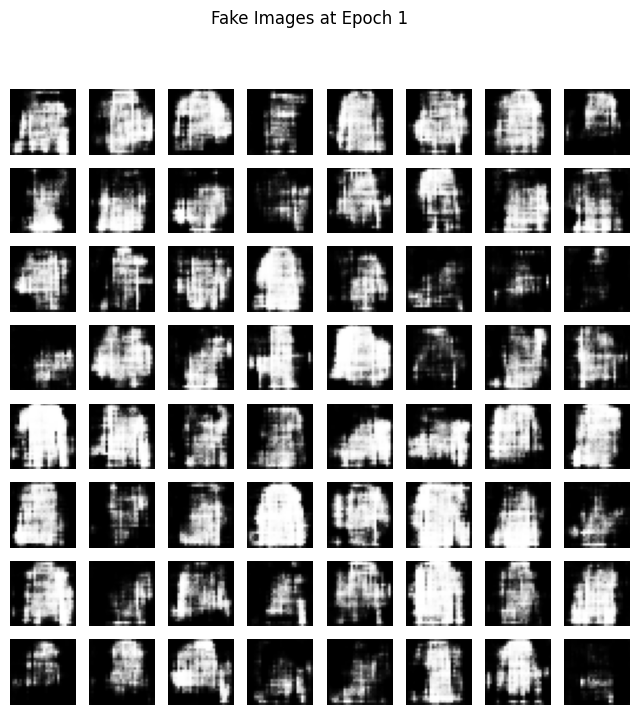

Epoch [2/50], Loss D: 0.5537, Loss G: 1.3815


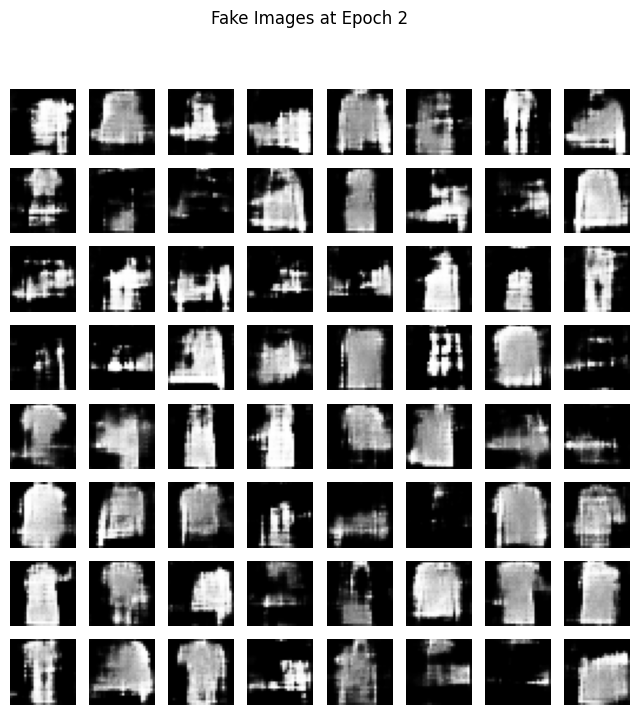

Epoch [3/50], Loss D: 0.9621, Loss G: 2.4123


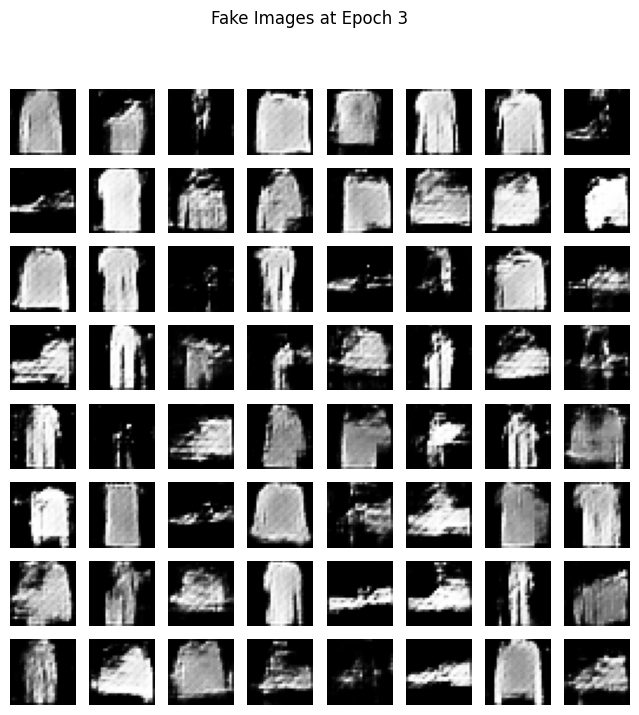

Epoch [4/50], Loss D: 0.9166, Loss G: 1.6261


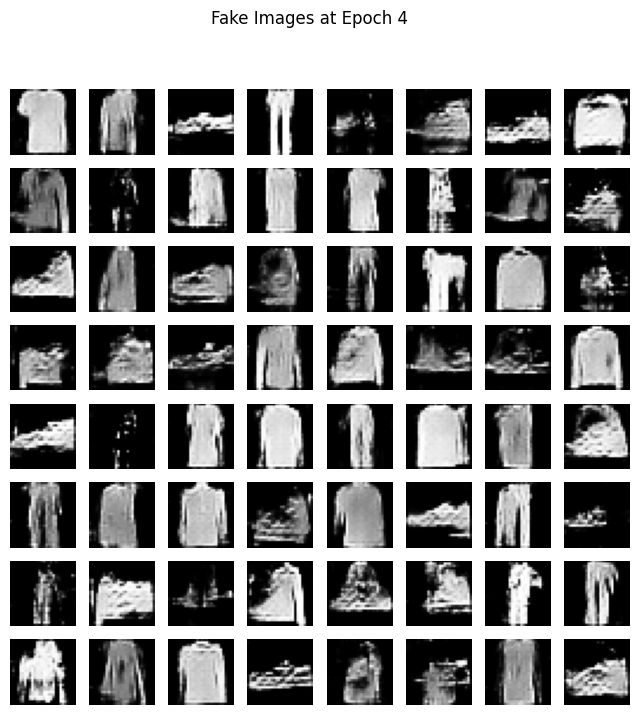

Epoch [5/50], Loss D: 0.9215, Loss G: 1.4474


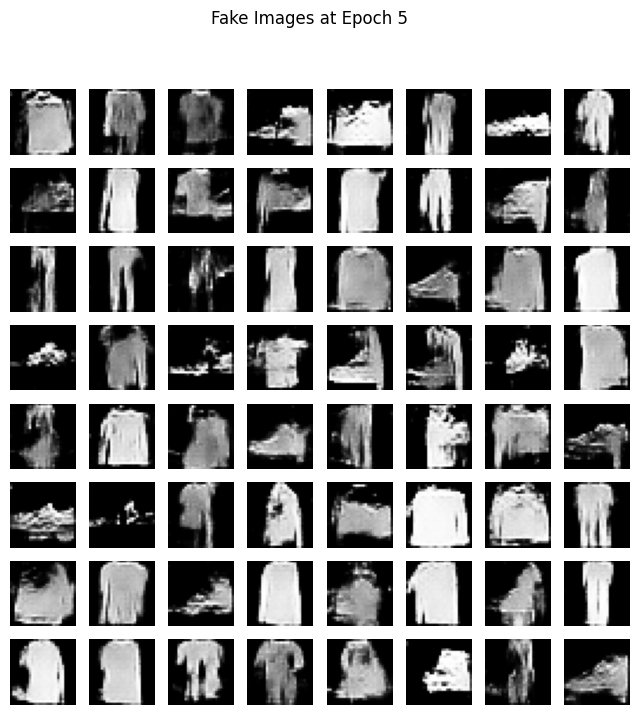

Epoch [6/50], Loss D: 1.1773, Loss G: 2.0427


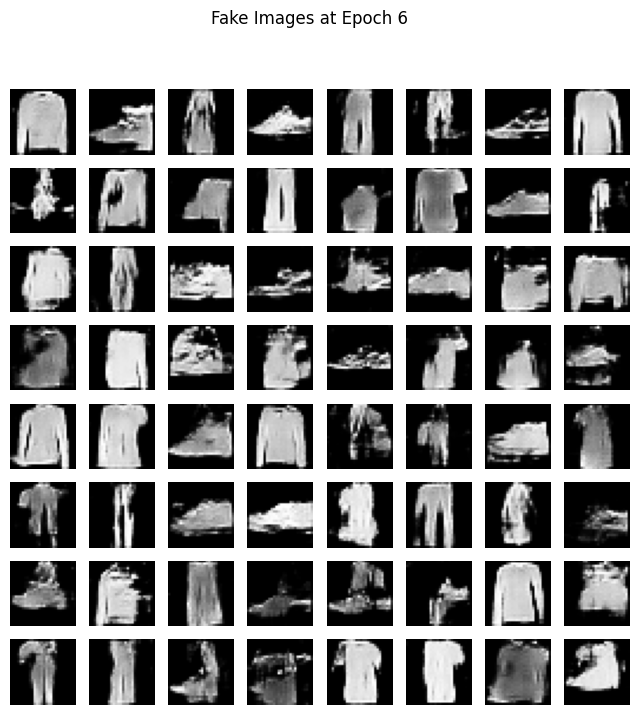

Epoch [7/50], Loss D: 0.9890, Loss G: 1.1496


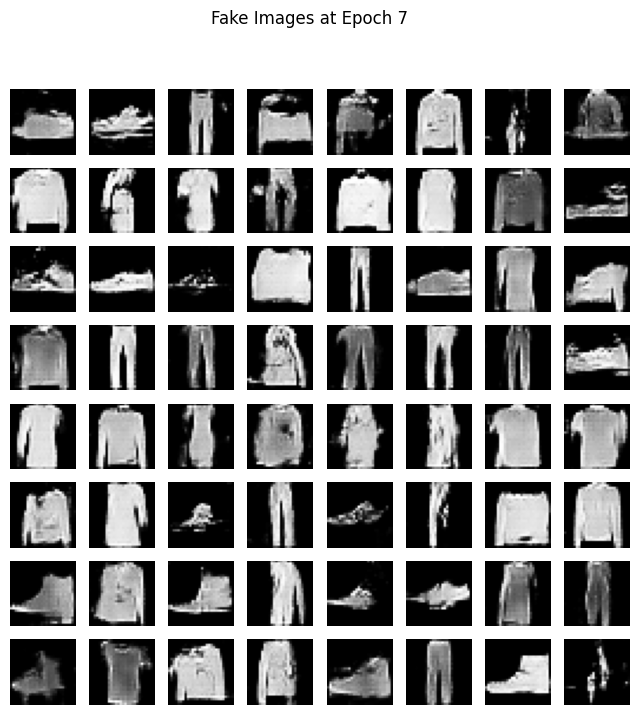

Epoch [8/50], Loss D: 0.9674, Loss G: 1.5169


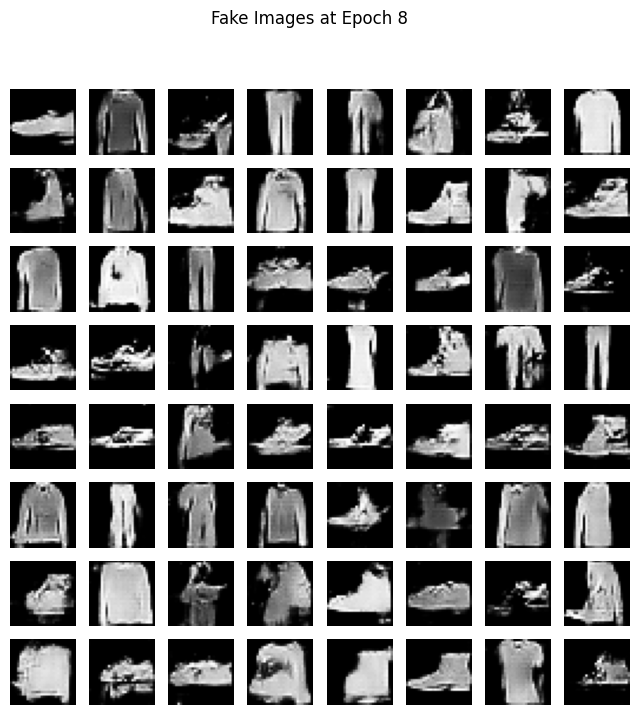

Epoch [9/50], Loss D: 1.0512, Loss G: 1.9595


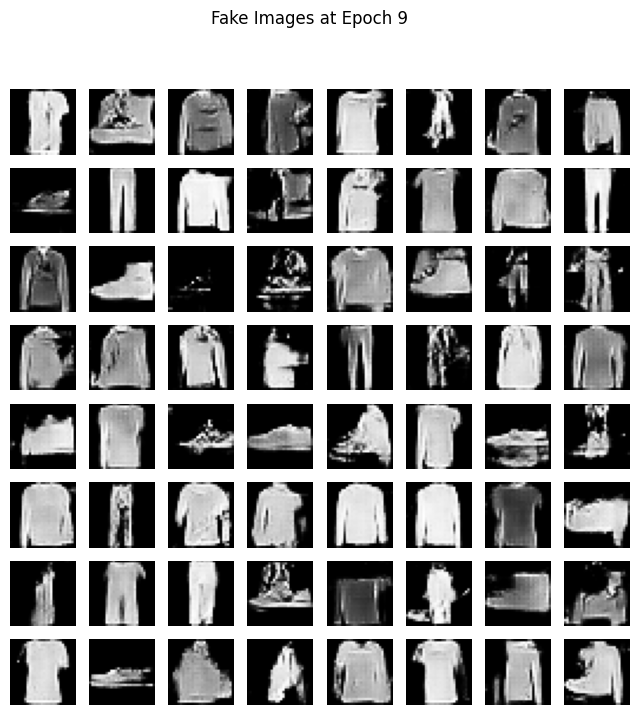

Epoch [10/50], Loss D: 1.0778, Loss G: 1.5970


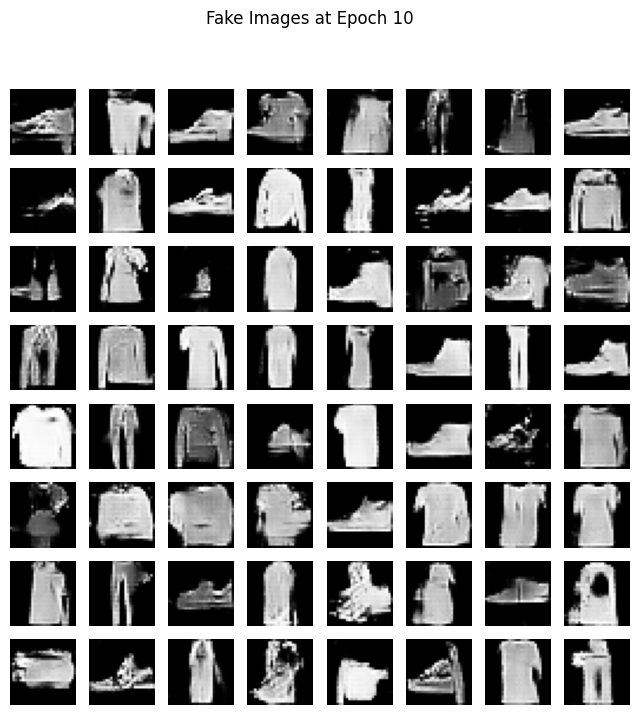

Epoch [11/50], Loss D: 1.0422, Loss G: 1.3280


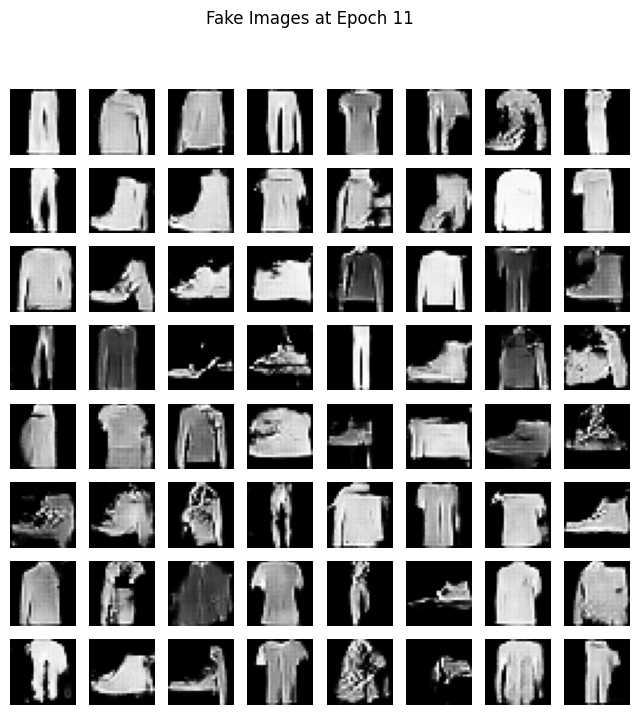

Epoch [12/50], Loss D: 1.0706, Loss G: 1.2820


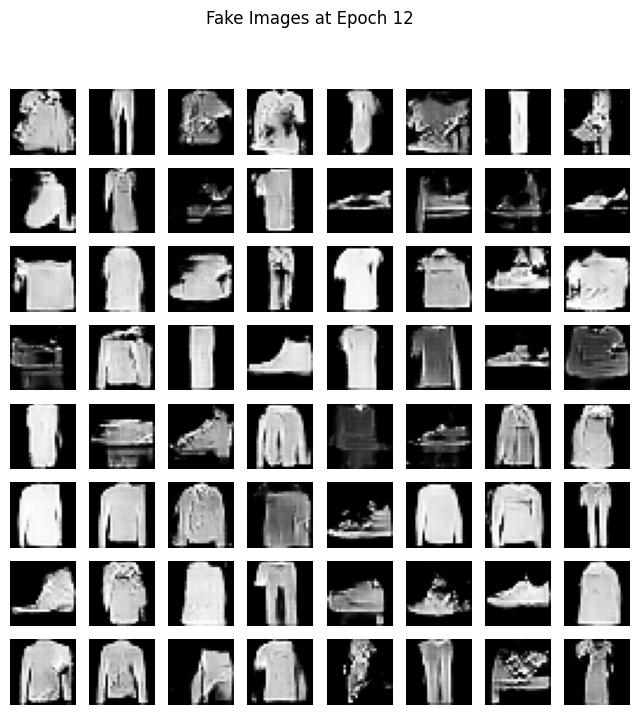

Epoch [13/50], Loss D: 1.1866, Loss G: 1.4346


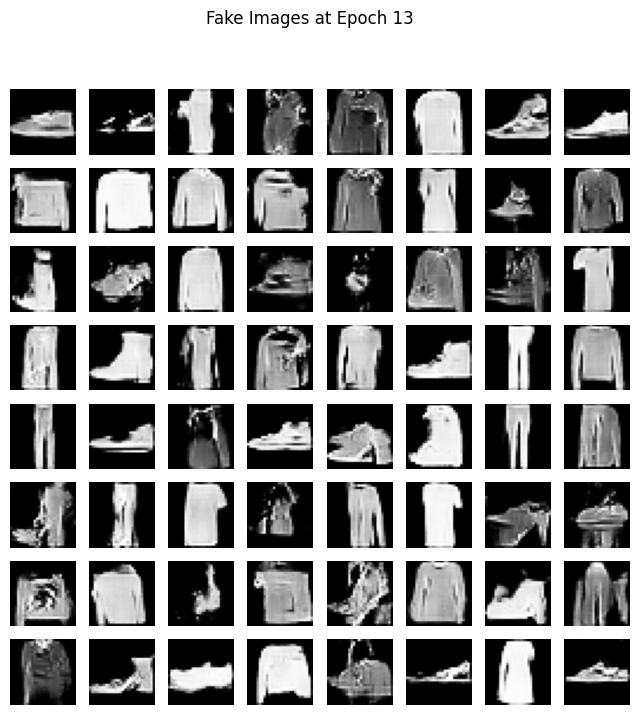

Epoch [14/50], Loss D: 1.0436, Loss G: 1.1230


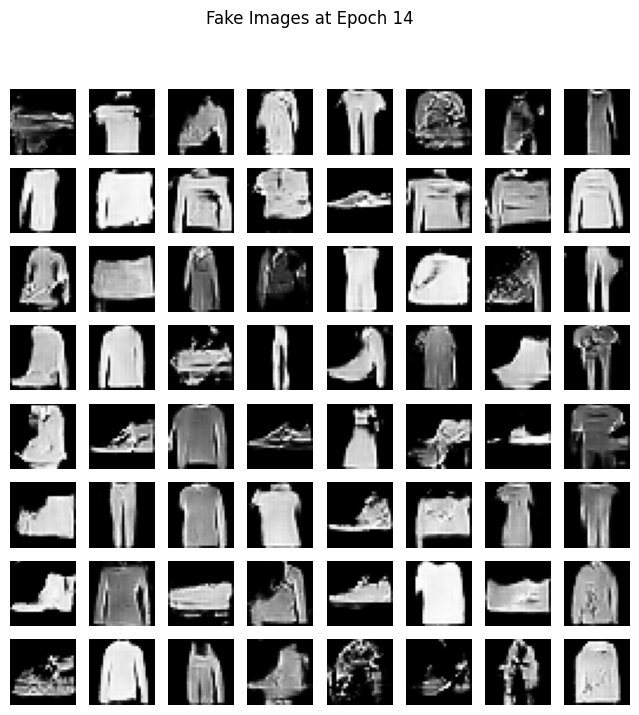

Epoch [15/50], Loss D: 1.1677, Loss G: 1.1211


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 128
z_dim = 100
lr = 0.0002
epochs = 50
image_size = 28

# Data Loading using Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=transform, download=True
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator: FC + ConvTranspose2d to produce 28x28 images
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            # Upsample from 7x7 to 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Upsample from 14x14 to 28x28
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 7, 7)
        x = self.deconv(x)
        return x

# Discriminator: CNN that processes 28x28 images
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Downsample 28x28 -> 14x14
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # Downsample 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

initialize_weights(generator)
initialize_weights(discriminator)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

def plot_fake_images(epoch, generator, z_dim):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(64, z_dim, device=device)
        fake_images = generator(noise).cpu()
    fake_images = fake_images * 0.5 + 0.5  # Denormalize
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(fake_images[i*8+j].squeeze(), cmap='gray')
            ax[i, j].axis('off')
    plt.suptitle(f'Fake Images at Epoch {epoch+1}')
    plt.show()
    generator.train()

# Training Loop
for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # Train Discriminator
        noise = torch.randn(current_batch_size, z_dim, device=device)
        fake_images = generator(noise)
        outputs_real = discriminator(real_images)
        loss_real = criterion(outputs_real, real_labels)
        outputs_fake = discriminator(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)
        loss_D = loss_real + loss_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        noise = torch.randn(current_batch_size, z_dim, device=device)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images)
        loss_G = criterion(outputs_fake, real_labels)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
    plot_fake_images(epoch, generator, z_dim)
